## Importowanie bibliotek
Biblioteka `morfeusz2` posłuży do lematyzacji, `plwordnet` i Słowosieć do analizy sentymentu. 

>**Słowosieć** (ang. PlWordNet) – baza danych leksykalno-semantycznych języka polskiego typu wordnet. Zawiera zestawy synonimicznych jednostek leksykalnych (synsety) opisanych krótkimi definicjami. Słowosieć służy jako słownik, w którym pojęcia (synsety) i poszczególne znaczenia wyrazów (jednostki leksykalne) zdefiniowane są poprzez miejsce w sieci wzajemnych relacji, odzwierciedlających system leksykalny polszczyzny. Słowosieć jest także wykorzystywana jako jeden z podstawowych zasobów do budowy programów przetwarzających język polski. ([Wikipedia](https://pl.wikipedia.org/wiki/S%C5%82owosie%C4%87))


- http://morfeusz.sgjp.pl/download/
- https://slowosiec.pl/

In [287]:
# import plwordnet
import morfeusz2
import pandas as pd
import numpy as np

In [288]:
# biblioteki do wizualizacji danych
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib_inline.backend_inline import set_matplotlib_formats
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from PIL import Image

set_matplotlib_formats('svg')

## Opis danych
Dane pochodzą z Reddita i Wykopu, zostały one zescrapowane przy uwzględnieniu następujących tagów: 
>wybory,prezydent,prezydenckie,debata,prezydencka,
>Zandberg,Biejat,Nawrocki,Trzaskowski,Hołownia,Mentzen,Braun,
>Maciak,Woch,Jakubiak,Senyszyn,Bartoszewicz,Stanowski,Końskie

[Nasza dokumentacja procesu webscrapingu](https://github.com/dpiotrkowski/PSI-analiza-sentymentu/blob/main/src/README.md)

![](img/loga.png)

## Wstępne przetwarzanie tekstu
W tym punkcie podejmiemy następujące kroki:
1. Usunięcie niepotrzebnych znaków z tekstu źródłowego
2. Autokorekta tekstu
3. Lematyzacja za pomocą Morfeusza
4. Usunięcie stop słów z lematów
   
Na początku załadujmy polski słownik sentymentu (ręcznie przefiltrowany `plwordnet` w csv). 

In [289]:
slownik_sentymentu = pd.read_csv('słowniki/SłownikSentymentu.csv', sep=';',encoding='cp1250')
# print(slownik_sentymentu.columns.tolist())

Wczytujemy zescrapowane pliki tekstowe z Reddita/Wykopu i dzielimy na pojedyncze słowa. Na samym końcu tworzymy ramkę danych, gdzie każde słowo jest w osobnym wierszu.

In [290]:
with open('data/results_reddit.txt', 'r', encoding='utf-8') as file:
    reddit_messy = file.read()
with open('data/results_wykop.txt', 'r', encoding='utf-8') as file:
    wykop_messy = file.read()
#slowa_r = tekst_caly_r.split()
#ramka_slow_r = pd.DataFrame(slowa_r, columns=['słowa'])

Kolejnym krokiem będzie przeczyszczenie wczytanego tekstu, czyli:
- usunięcie znaków interpunkcyjnych
- usunięcie niepożądanych słów z tekstu źródłowego
- usunięcie wszystkich linków z wpisów
- usunięcie tagów (`#` popularne na Wykopie)
- usunięcie liczb
- usunięcie polskich stop słów
  
W tym celu korzystamy z prostych list comprehensions.

### 1. Czyszczenie tekstu

In [291]:
niechciane_slowa_reddit = ['r/','Tytuł','tytuł', 'Treść','treść','Tag', 'Subreddit','rpolska']
niechciane_slowa_wykop = ['BRAK', 'TREŚCI', 'Tytuł','tytuł', 'Treść','treść','Tag', 'Subreddit']

def text_roomba(text, unwanted_words):
    # Znaki interpunkcyjne
    punctuation = '-,? .>:"/[]+=!%<*|–„( ͡° ͜ʖ ͡°)'    
    table = str.maketrans('', '', punctuation)
    
    words = text.split()
    # Wszystkie słowa z małej litery
    cleaned_words = [word.translate(table).lower() for word in words]  
    # Filtrowanie slow
    filtered_words = [word for word in cleaned_words if word not in unwanted_words and word != '']

    # Usuwanie linkow
    filtered_words_no_links = [
        word for word in filtered_words
        if not (word.startswith('http') or word.startswith('www'))
    ]

    # Usuwanie tagow
    filtered_words_no_tags = [
        word for word in filtered_words_no_links
        if not word.startswith('#')
    ]
    # Usuwanie liczb
    filtered_words_final = [
        word for word in filtered_words_no_tags
        if not word.isdigit()
    ]
    return filtered_words_final

reddit_txt = text_roomba(reddit_messy, niechciane_slowa_reddit)
wykop_txt = text_roomba(wykop_messy, niechciane_slowa_wykop)

Na koniec tworzymy ramkę danych z przefiltrowanymi słowami.

In [292]:
df_reddit = pd.DataFrame(reddit_txt, columns=['slowa'])
df_wykop = pd.DataFrame(wykop_txt, columns=['slowa'])

### 2. Autokorekta tekstu

### 3. Lematyzacja
O Morfeuszu twórcy piszą, że w skrócie to słownik morfologiczny.
Matura z polskiego już za nami za równo w wersji podstawowej, jak i rozszerzonej, a z Morfeusza korzystamy w wersji ze słownikiem gramatyki języka polskiego - [SGJP](http://sgjp.pl/o-slowniku/#liczby). 

**Ważne pojęcia** – czytamy dokumentację twórców
>Celem hasłowania (lematyzacji) jest wskazanie dla każdego słowa tekstowego opisującej je jednostki słownika morfologicznego (leksemu). Jest to więc analiza morfologiczna (lub tagowanie) ograniczona tylko do części informacji o formach — do lematów.

> Przybliżone hasłowanie polegające na odcięciu ze słów części zmieniającej się przy odmianie bywa nazywane stemowaniem. Metoda ta ma sens dla języków o ograniczonej fleksji, ale dla polskiego daje wyniki wysoce niezadowalające. W kontekście Morfeusza mówimy więc o prawdziwym hasłowaniu.

([Analizator morfologiczny Morfeusz](http://morfeusz.sgjp.pl/doc/about/)) 

In [293]:
morfeusz = morfeusz2.Morfeusz()

def lemmatize_word(word):
    analyses = morfeusz.analyse(word)
    if analyses:
        # analyses to lista krotek: (start, end, (lemma, tag), score)
        # Bierzemy pierwszą lematę z analizy
        lemma = analyses[0][2][1]  # [0] - pierwszy wynik, [2] - tuple (base, lemma, tag), [1] - lemma
        return lemma
    else:
        return word

df_reddit['lemma'] = df_reddit['slowa'].apply(lemmatize_word)
df_wykop['lemma'] = df_wykop['slowa'].apply(lemmatize_word)

Najczęstsze słowa

In [294]:
df_reddit['lemma_clean'] = df_reddit['lemma'].apply(lambda x: x.split(':')[0])
lemma_counts_reddit = df_reddit['lemma_clean'].value_counts()

df_wykop['lemma_clean'] = df_wykop['lemma'].apply(lambda x: x.split(':')[0])
lemma_counts_wykop = df_wykop['lemma_clean'].value_counts()

### 4. Stopsłowa
W końcu możemy przeczyścić lematy ze zbędnych słów - stopwords (się, na, i, w, itp...). W pliku `stopwords-pl.txt` znajdują się wszystkie stopsłowa. Pochodzi on z https://github.com/stopwords-iso/stopwords-pl

In [295]:
with open('słowniki/stopwords-pl.txt', 'r', encoding='utf-8') as file:
    df_polish_stop_words = file.read().splitlines()

df_reddit = df_reddit[~df_reddit['lemma_clean'].isin(df_polish_stop_words)]
word_freq_reddit = df_reddit['lemma_clean'].value_counts().head(125)

df_wykop = df_wykop[~df_wykop['lemma_clean'].isin(df_polish_stop_words)]
word_freq_wykop = df_wykop['lemma_clean'].value_counts().head(125)

## Chmura słów

Wykorzystamy teraz biblioteki do wizualizacji danych `matplotlib` i `worldcloud` do stworzenia chmury słów. W ramce danych `czestosci_slow` nadal występują słowa, które mogłyby zostać usunięte np. *prezydent*, *kandydat*, *wybory*.

Tworząc chmurę słów za pomocą biblioteki [`wordcloud`](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html) można dodać stopsłowa, dodając argument `stopwords`. Jednak nie zdecydowaliśmy się na to, ponieważ usunięcie stopsłów przyda się nam również przy analizie sentymentu.


In [296]:
words_to_remove = ['polski', 'polska', 'kandydat', 'prezydent','tenże','wybory', 'oda']
filtered_word_freq_reddit = {word: freq for word, freq in word_freq_reddit.items() if word not in words_to_remove}
filtered_word_freq_wykop = {word: freq for word, freq in word_freq_wykop.items() if word not in words_to_remove}

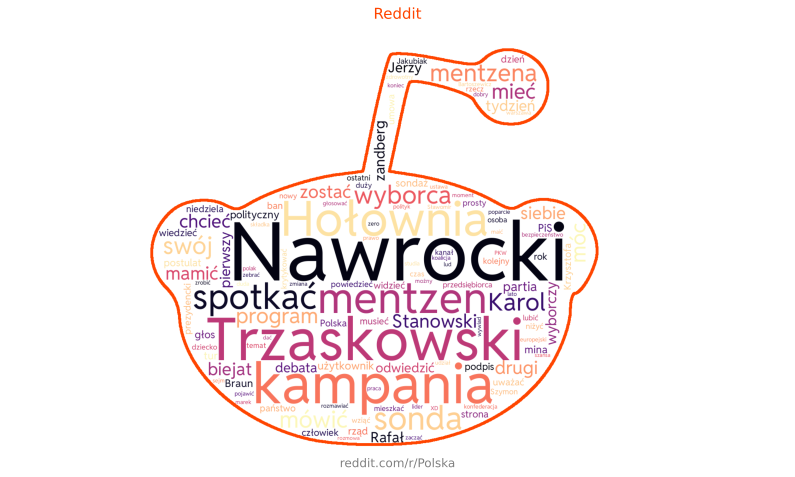

In [297]:
font_path = 'img/RedditSans.ttf'
font_prop = font_manager.FontProperties(fname=font_path)
mask_path = 'img/mask-reddit.png'  
mask = Image.open(mask_path)
mask = mask.convert("L")  # Convert to grayscale
mask = np.array(mask)

wc = WordCloud(font_path = font_path,
               mask=mask,
               width=1920, height=1080,
               background_color = "white",
               colormap = "magma",
               contour_width=12,
               contour_color='#ff4500')
wc.generate_from_frequencies(filtered_word_freq_reddit)

plt.figure(figsize=(14,11),dpi=300)
plt.axis('off')
plt.imshow(wc, interpolation="bilinear")
plt.title('Reddit', color='#ff4500', fontsize=15)
plt.text(0.5, 0.0, 'reddit.com/r/Polska', ha='center', va='center', fontsize=12, color='gray', transform=plt.gca().transAxes)
plt.show()

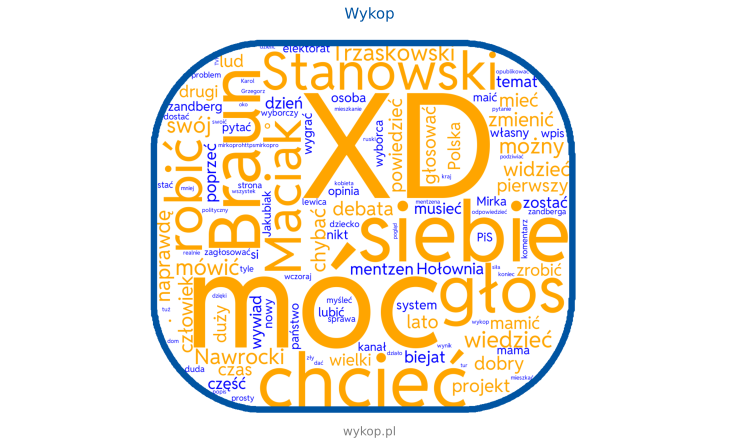

In [298]:
mask_path = 'img/mask-wykop.png'  
mask = Image.open(mask_path)
mask = mask.convert("L")  # Convert to grayscale
mask = np.array(mask)


def orange_center_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # Get the frequency of the word
    frequency = wc.words_.get(word, 0)
    
    # Assign orange to the most frequent words and blue to others
    if frequency > 0.3:  # Adjust this threshold based on your needs
        return "orange"
    else:
        return "blue"


wc = WordCloud(font_path = font_path,
               mask=mask,
               width=1920, height=1080,
               background_color = "white",
               color_func=orange_center_color_func,
               #colormap = "magma",
               contour_width=30,
               contour_color='#0054a2')
wc.generate_from_frequencies(filtered_word_freq_wykop)

plt.figure(figsize=(13,10),dpi=300)
plt.axis('off')
plt.imshow(wc, interpolation="bilinear")
plt.title('Wykop', color='#0054a2', fontsize=15)
plt.text(0.5, 0.0, 'wykop.pl', ha='center', va='center', fontsize=12, color='gray', transform=plt.gca().transAxes)
plt.show()

## Analiza sentymentu
Przechodzimy do właściwej analizy sentymentu.

In [299]:
# Dołączenie słownika sentymentu
df_reddit = df_reddit.merge(
    slownik_sentymentu,
    left_on='lemma_clean', 
    right_on='lemat',
    how='left'
)
df_wykop = df_wykop.merge(
    slownik_sentymentu,
    left_on='lemma_clean', 
    right_on='lemat',
    how='left'
)

# Zliczenie ilości słów o danym ładunku emocjonalnym
sentyment_suma_reddit = df_reddit.groupby('nachechowanie').size().reset_index(name='ilosc')
sentyment_suma_wykop = df_wykop.groupby('nachechowanie').size().reset_index(name='ilosc')

# Pominięcie słów bez przypisanego ładunku
sentyment_suma_reddit = sentyment_suma_reddit[sentyment_suma_reddit['nachechowanie'].notna()]
sentyment_suma_wykop = sentyment_suma_wykop[sentyment_suma_wykop['nachechowanie'].notna()]

Dołączamy słownik ładunków emocjonalnych do ostatecznie uzyskanej ramki danych i zliczamy wszystkie słowa o danym ładunku.

In [300]:

# Ustalenie kolejności argumentów
custom_order = ['+ m', '+ s', 'amb', '- s', '- m']
sentyment_suma_reddit['nachechowanie'] = pd.Categorical(
    sentyment_suma_reddit['nachechowanie'],
    categories=custom_order,
    ordered=True
)
sentyment_suma_wykop['nachechowanie'] = pd.Categorical(
    sentyment_suma_wykop['nachechowanie'],
    categories=custom_order,
    ordered=True
)

sentyment_suma_reddit = sentyment_suma_reddit.sort_values('nachechowanie', ascending=False)
sentyment_suma_wykop = sentyment_suma_wykop.sort_values('nachechowanie', ascending=False)

# Mapa kolorów dla skali emocji
color_map = {
    '+ m': '#2ecc40',   # Zielony
    '+ s': '#a3e048',   # Jasnozielony
    'amb': '#ffd700',   # Żółty
    '- s': '#ff8c00',   # Pomarańczowy
    '- m': '#e74c3c'    # Czerwony
}
sentyment_suma_reddit['color'] = sentyment_suma_reddit['nachechowanie'].map(color_map)
sentyment_suma_wykop['color'] = sentyment_suma_wykop['nachechowanie'].map(color_map)

# Mapa opisowych nazw dla skali emocji
label_map = {
    '+ m': 'bardzo pozytywny',
    '+ s': 'pozytywny',
    'amb': 'niejednoznaczny',
    '- s': 'negatywny',
    '- m': 'bardzo negatywny'
}

 Rezultat zostaje przedstawiony na wykresie lizakowym za pomocą biblioteki `matplotlib`.

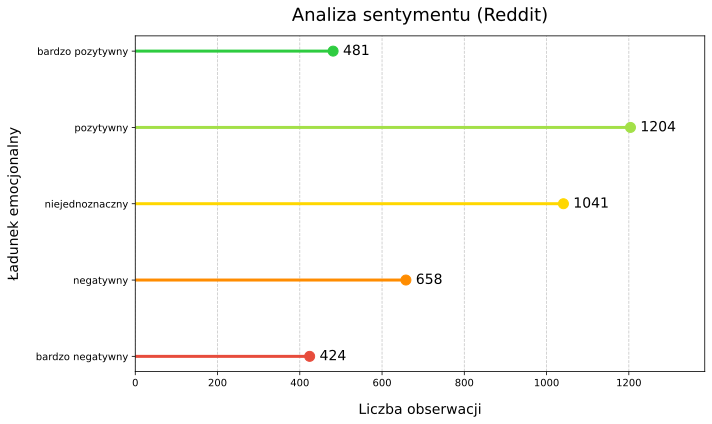

In [301]:
# Nowa kolumna z opisowymi nazwami do wyświetlenia na osi Y
sentyment_suma_reddit['label'] = sentyment_suma_reddit['nachechowanie'].map(label_map)
plt.figure(figsize=(10, 6))

# Wykres
for idx, row in sentyment_suma_reddit.iterrows():
    plt.hlines(
        y=row['label'],
        xmin=0,
        xmax=row['ilosc'],
        color=row['color'],
        linewidth=3
    )
    plt.plot(
        row['ilosc'],
        row['label'],
        'o',
        markersize=10,
        color=row['color']
    )
    plt.text(
        row['ilosc'] + max(sentyment_suma_reddit['ilosc']) * 0.02,
        row['label'],
        str(row['ilosc']),
        va='center',
        ha='left',
        fontsize=14,
        color='black'
    )

plt.title('Analiza sentymentu (Reddit)', fontsize=18, pad=15)
plt.xlabel('Liczba obserwacji', labelpad=15, fontsize = 14)
plt.ylabel('Ładunek emocjonalny', labelpad=15, fontsize = 14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
max_ilosc = sentyment_suma_reddit['ilosc'].max()
plt.xlim(0, max_ilosc * 1.15)
plt.tight_layout()
plt.show()

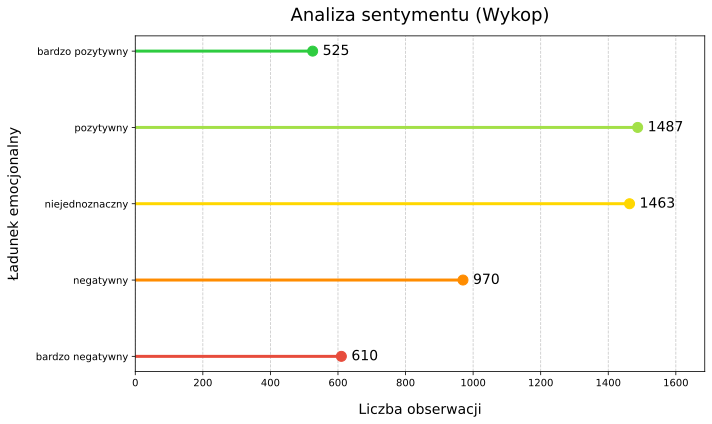

In [302]:
# Nowa kolumna z opisowymi nazwami do wyświetlenia na osi Y
sentyment_suma_wykop['label'] = sentyment_suma_wykop['nachechowanie'].map(label_map)
plt.figure(figsize=(10, 6))

# Wykres
for idx, row in sentyment_suma_wykop.iterrows():
    plt.hlines(
        y=row['label'],
        xmin=0,
        xmax=row['ilosc'],
        color=row['color'],
        linewidth=3
    )
    plt.plot(
        row['ilosc'],
        row['label'],
        'o',
        markersize=10,
        color=row['color']
    )
    plt.text(
        row['ilosc'] + max(sentyment_suma_wykop['ilosc']) * 0.02,
        row['label'],
        str(row['ilosc']),
        va='center',
        ha='left',
        fontsize=14,
        color='black'
    )

plt.title('Analiza sentymentu (Wykop)', fontsize=18, pad=15)
plt.xlabel('Liczba obserwacji', labelpad=15, fontsize = 14)
plt.ylabel('Ładunek emocjonalny', labelpad=15, fontsize = 14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
max_ilosc = sentyment_suma_reddit['ilosc'].max()
plt.xlim(0, max_ilosc * 1.40)
plt.tight_layout()
plt.show()

## Wystąpienia poszczególnych kandydatów
Teraz skupimy się bezpośrednio na kwestii obecnych wyborów. Najpierw zliczymy ile razy wspomniano poszczególnych kandydatów, zliczając wystąpienia ich nazwisk odmienionych przez wszystkie przypadki

Minus tej metody: Internauci uwielbiają nadawać ksywki, których tutaj nie uwzględniamy.

In [303]:
df_kandydaci_r = df_reddit[['slowa']]
slownik_kandydaci = pd.read_csv('słowniki/slownik_kandydaci.csv', sep=',')
df_kandydaci_r = df_kandydaci_r.merge(
    slownik_kandydaci,
    left_on='slowa', 
    right_on='odmieniony',
    how='left'
)

count_kandydaci_r = pd.DataFrame({'kandydaci': ['Trzaskowski', 'Nawrocki', 'Mentzen', 'Hołownia','Biejat',
 'Zandberg','Braun','Stanowski','Senyszyn','Jakubiak','Bartoszewicz','Woch','Maciak']})
wystapienia = df_kandydaci_r['mianownik'].value_counts()
count_kandydaci_r['wystapienia'] = count_kandydaci_r['kandydaci'].map(wystapienia).fillna(0).astype(int)
kandydaci_posortowani_r = count_kandydaci_r.sort_values(by='wystapienia', ascending=False)
print('Reddit:')
print(kandydaci_posortowani_r)

df_kandydaci_w = df_wykop[['slowa']]
slownik_kandydaci = pd.read_csv('słowniki/slownik_kandydaci.csv', sep=',')
df_kandydaci_w = df_kandydaci_w.merge(
    slownik_kandydaci,
    left_on='slowa', 
    right_on='odmieniony',
    how='left'
)

count_kandydaci_w = pd.DataFrame({'kandydaci': ['Trzaskowski', 'Nawrocki', 'Mentzen', 'Hołownia','Biejat',
 'Zandberg','Braun','Stanowski','Senyszyn','Jakubiak','Bartoszewicz','Woch','Maciak']})
wystapienia = df_kandydaci_w['mianownik'].value_counts()
count_kandydaci_w['wystapienia'] = count_kandydaci_w['kandydaci'].map(wystapienia).fillna(0).astype(int)
kandydaci_posortowani_w = count_kandydaci_w.sort_values(by='wystapienia', ascending=False)
print('Wykop:')
print(kandydaci_posortowani_w)

Reddit:
       kandydaci  wystapienia
1       Nawrocki          158
2        Mentzen           97
0    Trzaskowski           70
3       Hołownia           62
7      Stanowski           33
5       Zandberg           31
4         Biejat           27
6          Braun           22
9       Jakubiak           17
10  Bartoszewicz           13
12        Maciak           12
8       Senyszyn            7
11          Woch            7
Wykop:
       kandydaci  wystapienia
6          Braun           62
7      Stanowski           59
12        Maciak           53
0    Trzaskowski           50
2        Mentzen           46
5       Zandberg           45
1       Nawrocki           42
3       Hołownia           31
4         Biejat           27
9       Jakubiak           21
10  Bartoszewicz           11
8       Senyszyn            9
11          Woch            7


## Wykres częstości wystąpień nazwisk kandydatów

In [304]:
# tu będzie kod wykresu

## Asocjacje dla nazwisk kandydatów
Tym razem tekst musi zostać podzielony na całe wypowiedzi, a nie słowa.

In [ ]:
import re
with open('data/results_reddit.txt', 'r', encoding='utf-8') as file:
    tekst_asoc_r = file.read()

# Usuwanie listy wyrazow
words_to_remove = ['r/Polska', 'polski', 'polska', 'kandydat', 'prezydent','tenże','wybory', 'oda']
pattern_words = r'\b(?:' + '|'.join(words_to_remove) + r')\b'

zmieniane = [
    # Zamiana "?" i "!" na kropki
    (r'[?!]', '.'),          
    # Usuwanie linków i hashtagów         
    (r'\bhttps?:\S*|#\w+|' + pattern_words, ''),
    # Usuwanie znaków specjalnych i liczb       
    (r'[{}]|\d+'.format(re.escape("''\"*,:;>[]()%|<+=")), ''),
    # Zamiana / na spację
    (r'/', ' '),
    # Usuwanie wielokrotnych spacji                      
    (r'\s+', ' ')                     
]
for zmieniane, zmiana in zmieniane:
    tekst_asoc_r = re.sub(zmieniane, zmiana, tekst_asoc_r)
zdania_asoc_r = [s.strip() for s in re.split(r'[.\n]+', tekst_asoc_r) if s]

['Zwolennicy Nawrockiego użyli zdjęcia ze Strajku Kobiet do grafiki nawołującej do głosowania na Nawrockiego', 'Źródło Nawrocki miał pożyczyć panu Jerzemu pieniądze', 'procent rocznie Żyją w Tobie dwa wilki WTF', 'Potrafię zrozumieć wiele rzeczy ale co do chuja', 'Granica absurdu wywalona w kosmos', 'Pojechał tam jakiś nieznany szerzej chłopek no teraz już znany głównie z tego że kandyduje na urząd prezydenta RP i robi w chuja starych ludzi na mieszkania i ot tak strzałem z dupska ogarnął to', 'Oni są poważni', 'Moja opinia o kandydatach na Prezydenta RP Moja opinia o kandydatach na Prezydenta RP w kolejności alfabetycznej według nazwiska', 'Uwaga będzie długo', 'Artur Bartoszewicz Na starcie pan Artur zaliczył poważną wtopę bo ewidentnie kupił podpisy na listach poparcia jest w tym jednak tak zuchwały że nie sposób nie docenić pod kątem opowiadania historii', 'Potem był wywiad u Stanowskiego jeden z najdziwniejszych jakie widziałem i nie dziwię się że dzwoniący neurolog zobaczył w tym

Następnie dokonujemy lematyzacji i usunięcia stopwords z zachowaniem podziału na zdania.

In [306]:
# lematyzacja
morfeusz = morfeusz2.Morfeusz()

# Funkcja do lematyzacji pojedynczego słowa
def lemmatize(word: str) -> str:
    try:
        analysis = morfeusz.analyse(word)
        if analysis:
            return analysis[0][2][1].split(':')[0]
        return word
    except:
        return word

# Lematyzacja zdań z zachowaniem struktury
asoc_lem_r = []
for zdanie in zdania_asoc_r:
    # Dzielimy zdanie na słowa, lematyzujemy i łączymy z powrotem
    lematyzowane_slowa = [lemmatize(slowo) for slowo in zdanie.split()]
    asoc_lem_r.append(' '.join(lematyzowane_slowa))

# Usuwanie stopwords
def usun_stopwords(sentence, stopwords):
    words = sentence.split()
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)

asoc_lem_sw_r = [usun_stopwords(zdanie, df_polish_stop_words) for zdanie in asoc_lem_r]

# Zamiana na lowercase
asoc_gotowe_r = [zdanie.lower() for zdanie in asoc_lem_sw_r]

['zwolennica nawrocki użyć zdjęcia strajk kobieta grafik nawołujący głosowanie nawrocki', 'źródło nawrocki mieć pożyczyć jerzy pieniądz', 'procent rocznie żyć wilki wtf', 'potrafić zrozumieć rzecz chuj', 'granica absurd wywalić kosmos', 'pojechać znać szeroko chłopek znać głównie kandydować urząd prezydent rp robić chuj stary człowiek mieszkanie ot strzał dupsko ogarnąć', 'poważnić', 'opinia kandydat prezydent rp opinia kandydat prezydent rp kolejność alfabetyczny nazwisko', 'uwaga długo', 'artur bartoszewicz starcie artur zaliczyć poważny wtopa ewidentnie kupić podpis lista poparcie zuchwały docenić kąt opowiadanie historia', 'potem wywiad stanowski dziwny widzieć dziwić dzwonić neurolog zobaczyć objaw choroba', 'klasyczny polityczny plankton plus lepsze występ kolejny debata pewny poziom oczywiście', 'ciekawy żona szkoda ujrzeć piękny mądry kobieta', 'magdalena biejat jednać zły kandydatka zdecydować zły stawka parlamentarny zignorować zdradziecki działać dowiedzieć spółka pewno wybo

Macierz częstości słów

In [307]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(asoc_gotowe_r)
df_asoc_r = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
m_korelacji_r = df_asoc_r.corr(method='pearson')
# Funkcja znajdująca słowa najbardziej skorelowane z podanym słowem
def findAssocs(correlation_matrix, term, cor_limit=0.5):      
    if term not in correlation_matrix.columns:
        return f"Słowo '{term}' nie występuje"

    correlations = correlation_matrix[term]
    # Korelacje powyżej progu (z wyłączeniem samego terminu)
    high_correlations = correlations[(correlations >= cor_limit) & 
                                   (correlations.index != term)]
    #Zwracamy: Series z posortowanymi wartościami korelacji powyżej progu
    return high_correlations.sort_values(ascending=False)

Wykresy asocjacji dla Reddita

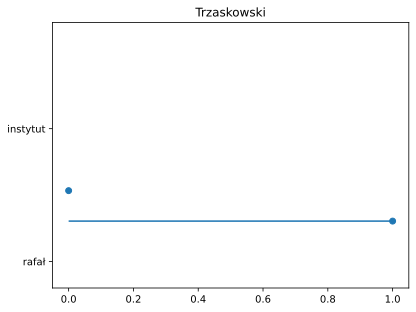

In [308]:
# Trzaskowski
trzaskowski_r = findAssocs(m_korelacji_r, 'trzaskowski', 0.3)
fig, ax = plt.subplots()
x = range(len(trzaskowski_r))
markerline, stemlines, baseline = ax.stem(trzaskowski_r, x, orientation='horizontal', basefmt=" ")
baseline.set_xdata([0, 0])  # baseline przy lewej krawędzi
ax.set_yticks(x)
ax.set_yticklabels(trzaskowski_r.index)
ax.set_ylim(-0.2, len(trzaskowski_r) - 0.2)
ax.set_title('Trzaskowski')
plt.show()

# Nawrocki
nawrocki_r = findAssocs(m_korelacji_r, 'nawrocki', 0.3)

# Mentzen
mentzen_r = findAssocs(m_korelacji_r, 'mentzen', 0.3)

# Hołownia
holownia_r = findAssocs(m_korelacji_r, 'hołownia', 0.3)

# Biejat
biejat_r = findAssocs(m_korelacji_r, 'biejat    ', 0.3)

# Zandberg
zandberg_r = findAssocs(m_korelacji_r, 'zandberg', 0.3)

# Braun
braun_r = findAssocs(m_korelacji_r, 'braun', 0.3)

# Stanowski
stanowski_r = findAssocs(m_korelacji_r, 'stanowski', 0.3)

# Senyszyn
senyszyn_r = findAssocs(m_korelacji_r, 'senyszyn', 0.3)

# Jakubiak
jakubiak_r = findAssocs(m_korelacji_r, 'jakubiak', 0.3)

# Bartoszewicz
bartoszewicz_r = findAssocs(m_korelacji_r, 'bartoszewicz', 0.3)

# Maciak
maciak_r = findAssocs(m_korelacji_r, 'maciak', 0.3)

# Woch
woch_r = findAssocs(m_korelacji_r, 'woch', 0.3)